In [1]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter
from skimage.measure import marching_cubes
import ipywidgets as widgets
from ipywidgets import interactive
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='Computer Modern')
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 0.0),  # blue  with alpha = 20%
})


In [3]:
a = 1.0
b = 1.0
c = 1.0
n_x = 0
n_y = 0
n_z = 0

# Read the data from the file
data = []
atoms = []
species_list = []
species_name_list = []
with open('../viability_BTO.dat', 'r') as file:
    for line in file:
        # if line starts with #grid, read the three values as n_x, n_y, n_z
        if line.startswith("#grid"):
            values = line.strip().split()
            n_x = int(values[1])
            n_y = int(values[2])
            n_z = int(values[3])
        # if line starts with #lat, read the three values as a, b, c
        if line.startswith("#lat"):
            values = line.strip().split()
            a = float(values[1])
            b = float(values[2])
            c = float(values[3])
        if line.startswith("#species"):
            values = line.strip().split()
            species_name_list = values[1:]
        if line.startswith("#"):
            continue
        values = line.strip().split()
        if len(values) == 3:
            atoms.append([float(values[0]), float(values[1]), float(values[2])])
        if len(values) >= 4:
            data.append([float(values[0]), float(values[1]), float(values[2]), float(values[3])])
            if len(values) > 4:
                species_list.append(int(values[4]))


# scale atom locations
atoms = np.array(atoms)
atoms[:,0] = atoms[:,0] * a
atoms[:,1] = atoms[:,1] * b
atoms[:,2] = atoms[:,2] * c

# set the min and max values for the grid
x_min = a * ( 0.0 )
x_max = a * ( 1.0 - 1.0/n_x )
y_min = b * ( 0.0 )
y_max = b * ( 1.0 - 1.0/n_y )
z_min = c * ( 0.0 )
z_max = c * ( 1.0 - 1.0/n_z )

# Create a 3D grid
grid_x, grid_y, grid_z = np.mgrid[x_min:x_max:complex(n_x), y_min:y_max:complex(n_y), z_min:z_max:complex(n_z)]
grid_points = np.vstack((grid_x.ravel(), grid_y.ravel(), grid_z.ravel())).T


In [4]:
grid_values = []
distance_threshold = 1e-3
for spec in sorted(set(species_list)):
    # Extract the coordinates and values
    x = np.array([row[0] for row, species in zip(data,species_list) if species == spec])
    y = np.array([row[1] for row, species in zip(data,species_list) if species == spec])
    z = np.array([row[2] for row, species in zip(data,species_list) if species == spec])
    values = np.array([row[3] for row, species in zip(data,species_list) if species == spec])

    # scale the data positions
    x = x * a
    y = y * b
    z = z * c

    # Calculate distances to the nearest known data point
    tree = cKDTree(np.c_[x, y, z])
    distances, _ = tree.query(grid_points, k=1)
    
    # Interpolate data onto the 3D grid
    grid_values.append(griddata((x, y, z), values, (grid_x, grid_y, grid_z), method='nearest', fill_value=0.0))
    # grid_values[spec] = np.nan_to_num(grid_values)

    # Reshape distances to match the grid shape
    distances = distances.reshape(grid_values[spec-1].shape)

    # Set threshold for distance (e.g., 1 unit)
    grid_values[spec-1][distances > distance_threshold] = 0  # Set to zero for points beyond the threshold


In [5]:

# # Apply Gaussian filter for smoothing
# grid_values = gaussian_filter(grid_values, sigma=1)  # Adjust sigma for more or less smoothing


In [6]:
# Function to plot atoms as spheres
def plot_atoms_as_spheres(ax, atoms, radius=0.5, resolution=(10, 5)):
    u = np.linspace(0, 2 * np.pi, resolution[0])
    v = np.linspace(0, np.pi, resolution[1])
    for atom in atoms:
        atom_x, atom_y, atom_z = atom
        # Generate sphere coordinates
        x_sphere = atom_x + radius * np.outer(np.cos(u), np.sin(v))
        y_sphere = atom_y + radius * np.outer(np.sin(u), np.sin(v))
        z_sphere = atom_z + radius * np.outer(np.ones(np.size(u)), np.cos(v))
        # Plot spheres with lower resolution
        ax.plot_surface(x_sphere, y_sphere, z_sphere, color='red', alpha=1.0, rstride=1, cstride=1)
        
def plot_atoms_as_scatter(ax, atoms, size=100, color='red'):
    ax.scatter(atoms[:,0], atoms[:,1], atoms[:,2], s=size, c=color, alpha=1.0)


In [7]:
# Define the plotting function
def plot_3d_heatmap(slice_level, species, axis):
    ax.cla()  # Clear the plot

    # Normalise slice level to the grid range
    if axis == 'c':
        slice_idx = int(slice_level * n_z)
        slice_data = grid_values[species-1][:, :, slice_idx]
        slice_pos = (grid_x[:, :, slice_idx], grid_y[:, :, slice_idx], grid_z[:, :, slice_idx])
    elif axis == 'b':
        slice_idx = int(slice_level * n_y)
        slice_data = grid_values[species-1][:, slice_idx, :]
        slice_pos = (grid_x[:, slice_idx, :], grid_y[:, slice_idx, :], grid_z[:, slice_idx, :])
    elif axis == 'a':
        slice_idx = int(slice_level * n_x)
        slice_data = grid_values[species-1][slice_idx, :, :]
        slice_pos = (grid_x[slice_idx, :, :], grid_y[slice_idx, :, :], grid_z[slice_idx, :, :])
    elif axis == 'ab':
        # get diagonal list of idx
        slice_idx_xy = [
            ( 
                round( ( -0.5 + slice_level ) * (n_x + 1) ) + i,
                round( ( -0.5 + slice_level ) * (n_y + 1) ) + j
            ) for i, j in zip(range(n_x,-1,-1), range(n_y+1))
            if ( round( ( -0.5 + slice_level ) * (n_x + 1) ) + i ) >= 0 and ( round( ( -0.5 + slice_level ) * (n_x + 1) ) + i ) < n_x and
            ( round( ( -0.5 + slice_level ) * (n_y + 1) ) + j ) >= 0 and ( round( ( -0.5 + slice_level ) * (n_y + 1) ) + j ) < n_y
        ]
        slice_idx_x = [ i for i, j in slice_idx_xy ]
        slice_idx_y = [ j for i, j in slice_idx_xy ]
        slice_data = grid_values[species-1][slice_idx_x, slice_idx_y, :]
        slice_pos = (grid_x[slice_idx_x, slice_idx_y, :], grid_y[slice_idx_x, slice_idx_y, :], grid_z[slice_idx_x, slice_idx_y, :])

    # Plot heatmap on the selected slice plane
    max_val = grid_values[species-1].max()
    if max_val == 0:
        max_val = 1
    img = ax.plot_surface(slice_pos[0], slice_pos[1], slice_pos[2],
                          facecolors=plt.cm.viridis(slice_data / max_val),
                          rstride=1, cstride=1, linewidth=0, antialiased=True, shade=False, alpha=0.8,
    )

    # Plot atoms as spheres
    plot_atoms_as_spheres(ax, atoms)
    # plot_atoms_as_scatter(ax, atoms, 200, 'red')
    
    # Set axis limits
    ax.set_xlim([0, a])
    ax.set_ylim([0, b])
    ax.set_zlim([0, c])
    
    # Labels and view adjustments
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(30, 45)
    plt.draw()


In [8]:
# Set up interactive sliders
slice_slider = widgets.FloatSlider(value=0.5, min=0, max=1-0.01, step=0.01, description='Slice Position:')
axis_selector = widgets.RadioButtons(options=['a', 'b', 'c', 'ab'], description='Axis:', value='c')
species_selector = widgets.Dropdown(options=sorted(set(species_list)), description='Species:')


interactive(children=(FloatSlider(value=0.5, description='Slice Position:', max=0.99, step=0.01), Dropdown(des…

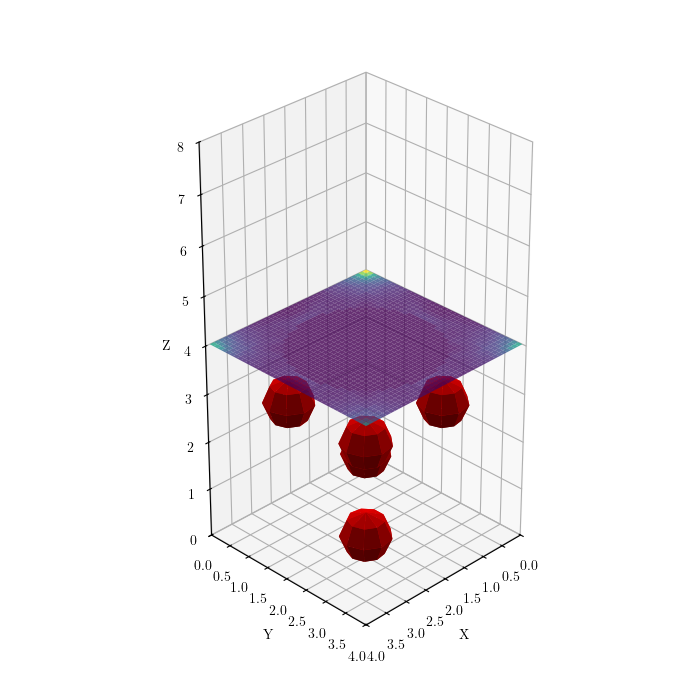

In [9]:
# Create the figure and axis
fig = plt.figure(figsize=(7, 7));
ax = fig.add_subplot(111, projection='3d');

# Set the aspect ratio based on the lattice parameters
ax.set_box_aspect([a, b, c])  # This scales the plot according to lattice ratios

# Set up interactive plot
interactive_plot = interactive(plot_3d_heatmap, slice_level=slice_slider, axis=axis_selector, species=species_selector)
output = interactive_plot.children[-1]
interactive_plot

In [10]:
from IPython.display import display
import ipywidgets as widgets
import tkinter as tk
from tkinter import filedialog

In [11]:
# Define the 2D plotting function
def plot_2d_slice(slice_level, species, axis):
    plt.clf()  # Clear the current figure

    # Normalize slice level to the grid range
    if axis == 'c':
        slice_idx = int(slice_level * n_z)
        slice_data = grid_values[species-1][:, :, slice_idx]
        plt.imshow(slice_data.T, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='viridis', aspect='auto')
        plt.xlabel('$x$ (\AA)')
        plt.ylabel('$y$ (\AA)')
    elif axis == 'b':
        slice_idx = int(slice_level * n_y)
        slice_data = grid_values[species-1][:, slice_idx, :]
        plt.imshow(slice_data.T, extent=(x_min, x_max, z_min, z_max), origin='lower', cmap='viridis', aspect='auto')
        plt.xlabel('$x$ (\AA)')
        plt.ylabel('$z$ (\AA)')
    elif axis == 'a':
        slice_idx = int(slice_level * n_x)
        slice_data = grid_values[species-1][slice_idx, :, :]
        plt.imshow(slice_data.T, extent=(y_min, y_max, z_min, z_max), origin='lower', cmap='viridis', aspect='auto')
        plt.xlabel('$y$ (\AA)')
        plt.ylabel('$z$ (\AA)')
    elif axis == 'ab':
        # get diagonal list of idx
        slice_idx_xy = [
            ( 
                round( ( -0.5 + slice_level ) * (n_x + 1) ) + i,
                round( ( -0.5 + slice_level ) * (n_y + 1) ) + j
            ) for i, j in zip(range(n_x,-1,-1), range(n_y+1))
            if ( round( ( -0.5 + slice_level ) * (n_x + 1) ) + i ) >= 0 and ( round( ( -0.5 + slice_level ) * (n_x + 1) ) + i ) < n_x and
            ( round( ( -0.5 + slice_level ) * (n_y + 1) ) + j ) >= 0 and ( round( ( -0.5 + slice_level ) * (n_y + 1) ) + j ) < n_y
        ]
        slice_idx_x = [ i for i, j in slice_idx_xy ]
        slice_idx_y = [ j for i, j in slice_idx_xy ]
        slice_data = grid_values[species-1][slice_idx_x, slice_idx_y, :]
        min_loc = 0.0
        max_loc = np.sqrt( (len(slice_idx_x) * a / n_x)**2 + (len(slice_idx_y) * b / n_y)**2 )
        plt.imshow(slice_data.T, extent=(min_loc, max_loc, z_min, z_max), origin='lower', cmap='viridis', aspect='auto')
        plt.xlabel(r'$xy$ (\AA)')
        plt.ylabel('$z$ (\AA)')

    plt.title(f'Slice through ${axis}$ = {slice_level:.2f}', fontsize=20)
    min_val = min(grid_value.min() for grid_value in grid_values)
    max_val = max(grid_value.max() for grid_value in grid_values)
    plt.clim(min_val, max_val)
    cbar = plt.colorbar(label='Viability')
    ax = plt.gca()
    ax.set_aspect('equal')
    # Set tick and label font size
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    plt.xlabel(plt.gca().get_xlabel(), fontsize=20)
    plt.ylabel(plt.gca().get_ylabel(), fontsize=20)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label(r'$P_{'+species_name_list[species-1]+r'}$', fontsize=20)
    # cbar.set_ticks(np.linspace(min_val, max_val, 4))
    cbar.ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4))
    cbar.ax.minorticks_on()


In [12]:
# Save the current plot as a PDF
def save_plot(b):
    slice_level = slice_slider_2d.value
    species = species_selector_2d.value
    axis = axis_selector_2d.value
    plot_2d_slice(slice_level, species, axis)
    # Open file dialog to select file path and name
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    file_path = filedialog.asksaveasfilename(defaultextension=".pdf", filetypes=[("PDF files", "*.pdf")])
    if file_path:
        fig = plt.gcf()
        fig.patch.set_facecolor('none')  # Set the face color to white
        ax = plt.gca()
        ax.patch.set_facecolor('none')  # Set the axes face color to white
        plt.savefig(file_path, bbox_inches='tight', pad_inches=0, facecolor=fig.get_facecolor(), edgecolor='none')
        print(f'Plot saved as {file_path}')

Button(description='Save Plot', style=ButtonStyle())

interactive(children=(FloatSlider(value=0.5, description='Slice Position:', max=0.99, step=0.01), Dropdown(des…

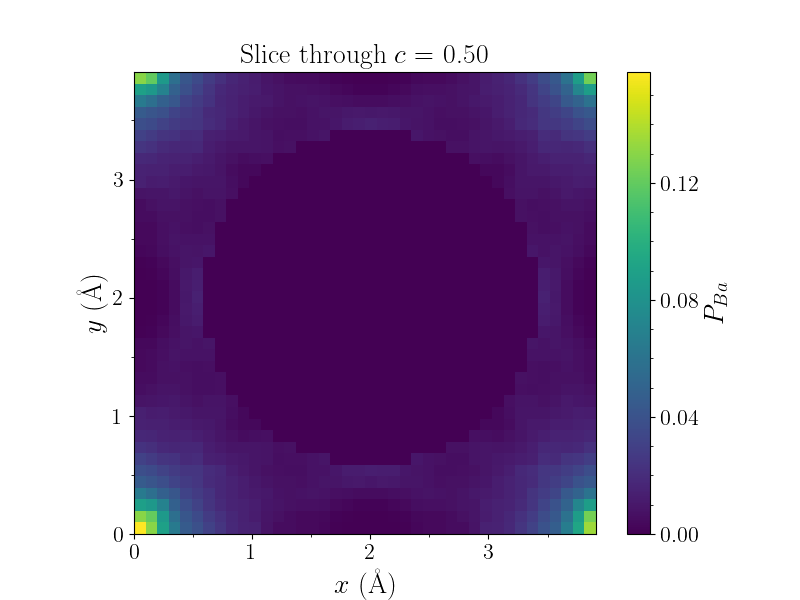

In [13]:
plt.figure(figsize=(8, 6))

save_button = widgets.Button(description="Save Plot")
save_button.on_click(save_plot)
display(save_button)

# Set up interactive sliders for 2D plot
slice_slider_2d = widgets.FloatSlider(value=0.5, min=0, max=1-0.01, step=0.01, description='Slice Position:')
axis_selector_2d = widgets.RadioButtons(options=['a', 'b', 'c', 'ab'], description='Axis:', value='c')
species_selector_2d = widgets.Dropdown(options=sorted(set(species_list)), description='Species:')

# Set up interactive plot for 2D slices
interactive_plot_2d = interactive(plot_2d_slice, slice_level=slice_slider_2d, axis=axis_selector_2d, species=species_selector_2d)
interactive_plot_2d
